In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [3]:
RESULTS_ROOT = pyprojroot.here() / 'results'

FIG_ROOT = pyprojroot.here() / 'doc' / 'article' / 'figures' / 'mainfig_tweetynet_v_svm'
FIG_ROOT.mkdir(exist_ok=True)

#### Munge data

In [4]:
segmentation_map = {
    'ground_truth': 'segmented audio, manually cleaned',
    'resegment': 'segmented audio, not cleaned',
    'semi-automated-cleaning': 'segmented audio, semi-automated cleaning',
    'not-cleaned': 'segmented audio, not cleaned',
    'manually-cleaned': 'segmented audio, manually cleaned'
}

In [5]:
hvc_dfs = []


csv_filename = 'segment_error_across_birds.hvc.csv'

for species in ('Bengalese_Finches', 'Canaries'):
    species_csv = RESULTS_ROOT / f'{species}/hvc/{csv_filename}'
    df = pd.read_csv(species_csv)

    df['Input'] = df['segmentation'].map(segmentation_map)
    df['Model'] = 'SVM'
    df['Species'] = species
    hvc_dfs.append(df)

hvc_df = pd.concat(hvc_dfs)

In [6]:
curve_df = []

for species in ('Bengalese_Finches', 'Canaries'):
    LEARNCURVE_RESULTS_ROOT = pyprojroot.here() / 'results' / species / 'learncurve'
    error_csv_path = LEARNCURVE_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
    df = pd.read_csv(error_csv_path)

    df = df[df.animal_id.isin(hvc_df.animal_id.unique())]
    df['Model'] = 'TweetyNet'
    df['Input'] = 'spectrogram'
    df['Species'] = species
    curve_df.append(df)

del df
curve_df = pd.concat(curve_df)

In [7]:
CLEANUP = 'min_segment_dur_majority_vote'

curve_df = curve_df[
    curve_df.cleanup == CLEANUP
]

In [8]:
all_df = pd.concat([hvc_df, curve_df])

all_df['Model, Input'] = all_df['Model'] + '; ' + all_df['Input']

all_df = convert_seg_error_rate_pct(all_df)

In [9]:
all_df.head()  # sanity check

,Unnamed: 0,animal_id,train_set_dur,replicate_num,segmentation,avg_segment_error_rate,Input,Model,Species,cleanup,...,model_name,results_dir,toml_path,training_replicate_csv_path,checkpoint_path,spect_scalar_path,min_segment_dur,avg_error,train_set_dur_ind,"Model, Input"
0,0.0,bl26lb16,75,1,not-cleaned,6.504848,"segmented audio, not cleaned",SVM,Bengalese_Finches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SVM; segmented audio, not cleaned"
1,1.0,bl26lb16,75,1,semi-automated-cleaning,1.966579,"segmented audio, semi-automated cleaning",SVM,Bengalese_Finches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SVM; segmented audio, semi-automated cleaning"
2,2.0,bl26lb16,75,1,manually-cleaned,0.404915,"segmented audio, manually cleaned",SVM,Bengalese_Finches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SVM; segmented audio, manually cleaned"
3,3.0,bl26lb16,75,2,not-cleaned,6.331379,"segmented audio, not cleaned",SVM,Bengalese_Finches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SVM; segmented audio, not cleaned"
4,4.0,bl26lb16,75,2,semi-automated-cleaning,1.861686,"segmented audio, semi-automated cleaning",SVM,Bengalese_Finches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"SVM; segmented audio, semi-automated cleaning"


In [10]:
gb = all_df.groupby(by=['Species', 'Model', 'Input', 'animal_id', 'train_set_dur'])
df_agg = gb.agg(
    mean_seg_err = pd.NamedAgg('avg_segment_error_rate', 'mean'),
    median_seg_err = pd.NamedAgg('avg_segment_error_rate', 'median'),
    std_seg_err = pd.NamedAgg('avg_segment_error_rate', 'std')
)

data = df_agg.reset_index()  # ``data`` DataFrame for use with ``seaborn``

In [11]:
STYLE = {'axes.facecolor': '#EAEAF2',
         'axes.grid': True,
         'grid.color': 'white',
         'grid.linestyle': '-'}
matplotlib.style.use(STYLE)


PALETTE = sns.color_palette('colorblind', n_colors=2)

MODEL_HUE_MAP = {
    'Bengalese_Finches': {
        'TweetyNet': PALETTE[0],
                'SVM': PALETTE[1],
    },
    'Canaries': {
        'TweetyNet': PALETTE[0],
        'SVM': PALETTE[1],
    },
}

DASHES = {
    'segmented audio, manually cleaned': (4, 1.5),
    'segmented audio, not cleaned': (1, 1),
    'segmented audio, semi-automated cleaning': (3, 1.25, 1.5, 1.25),
    'spectrogram': '',
}

#### actually plot figure

<ipython-input-12-0176aeab2c43>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_species['train_set_dur_ind'] = data_species['train_set_dur'].map(dur_int_map)


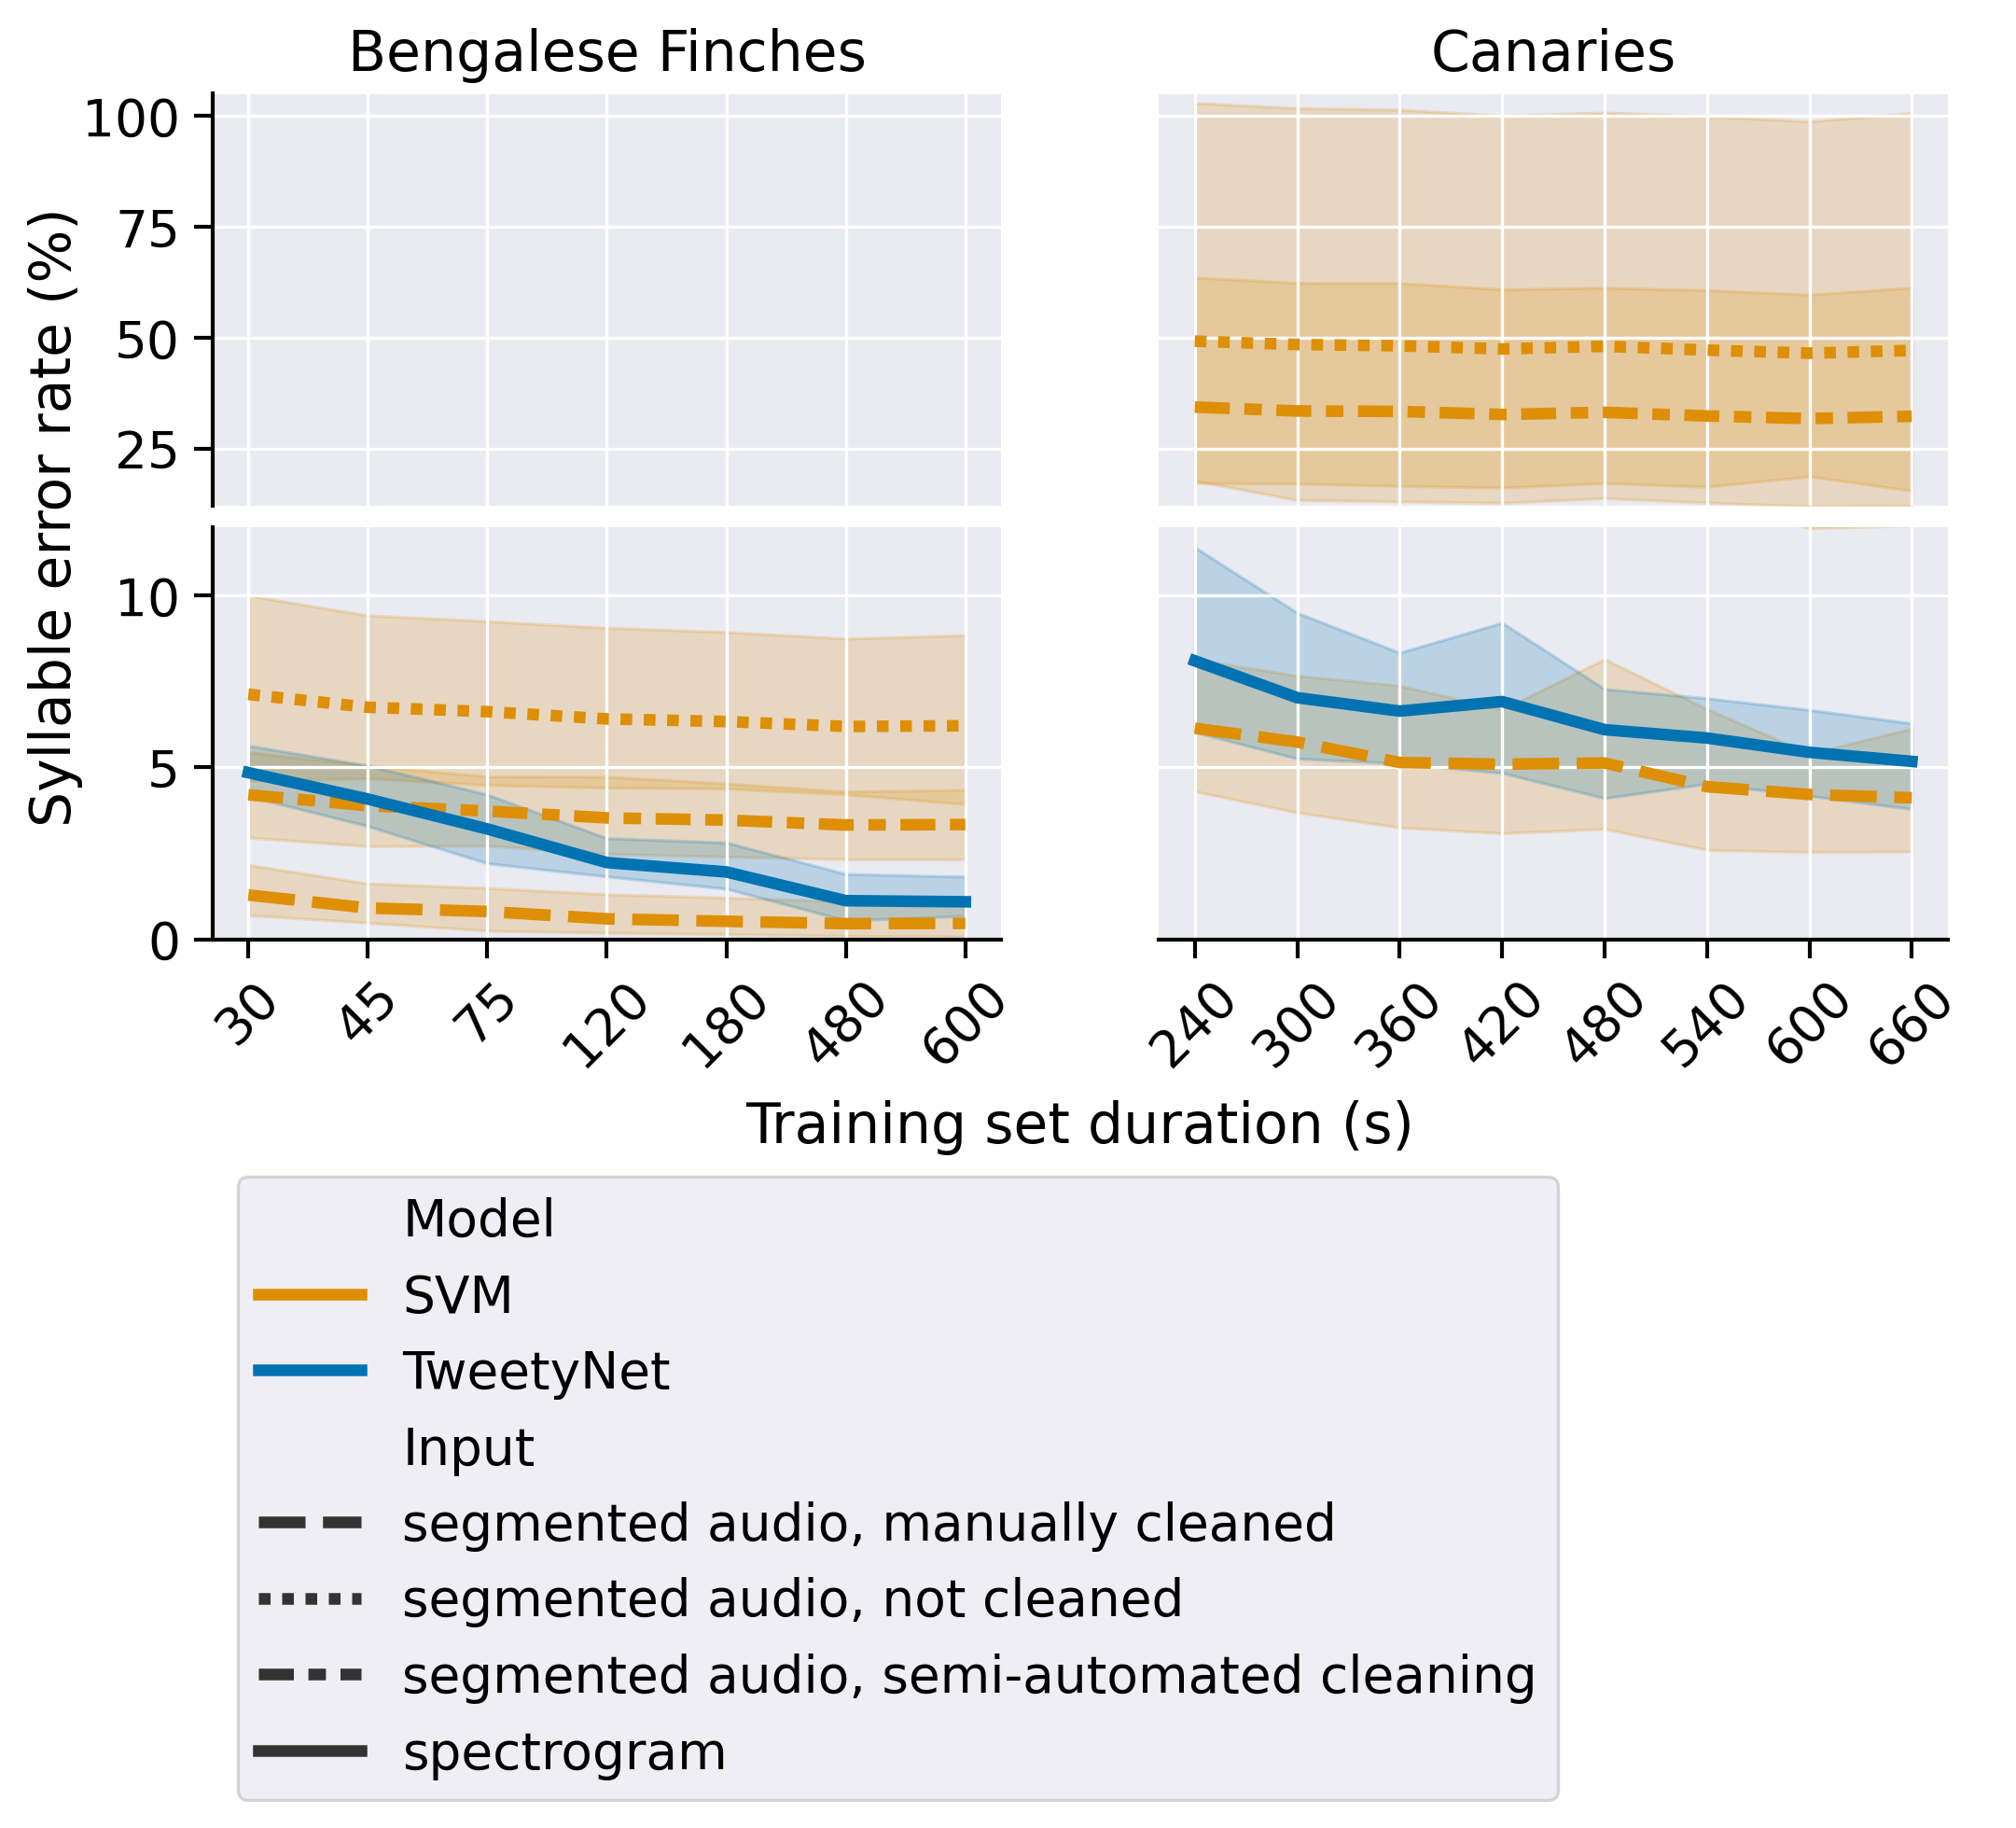

In [12]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 3})
# sns.set_style('darkgrid')

figsize = (8, 4)
dpi = 300

fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)

gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0.05)

ax_arr = []
for row in range(2):
    for col in range(2):
        ax_arr.append(fig.add_subplot(gs[row, col]))

ax_arr = np.array(ax_arr).reshape(2, 2)

MIN_TRAIN_SET_DUR_CANARY = 240

for col, species in enumerate(('Bengalese_Finches', 'Canaries')):
    # ---- get data
    data_species = data[data.Species == species]
    
    if species == 'Canaries':
        data_species = data_species[data_species.train_set_dur >= MIN_TRAIN_SET_DUR_CANARY]

    train_set_durs = sorted(data_species['train_set_dur'].unique())
    dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
    data_species['train_set_dur_ind'] = data_species['train_set_dur'].map(dur_int_map)

    TRAIN_DUR_IND_MAP = {
    k:v for k, v in zip(
        sorted(data_species['train_set_dur'].unique()), 
        sorted(data_species['train_set_dur_ind'].unique())
    )
    }

    # ---- set up to plot
    col_ax_arr = ax_arr[:, col]

    col_ax_arr[0].get_shared_x_axes().join(col_ax_arr[1])

#     col_ax_arr[0].spines['bottom'].set_visible(False)
#     col_ax_arr[1].xaxis.tick_bottom()
#     col_ax_arr[1].spines['top'].set_visible(False)
    

    palette = MODEL_HUE_MAP[species]

    # we plot the same data on both axes, and then change the ylims below
    for row, ax in enumerate(col_ax_arr):
        if col == 1 and row == 1:
            # let seaborn generate legend, then we get handles + labels and place under whole figure
            legend = True
        else:
            legend = False

        g = sns.lineplot(
            data=data_species,
            x='train_set_dur_ind',
            y='mean_seg_err',
            hue='Model',
            palette=palette,
            style='Input',
            dashes=DASHES,
            ax=ax,
            legend=legend,
        )

        ax.set_xlabel('')
        ax.set_ylabel('')

        
        if col == 1 and row == 1:
            handles, labels = ax.get_legend_handles_labels()
            g.legend_.remove()

    # svm_mean_seg_err_max_dur = data[
    #     (data.Model=='SVM') & (data.Input == 'audio, manually cleaned') & (data.train_set_dur_ind ==  6)
    # ].mean_seg_err.mean()

    # tweetynet_mean_seg_err_max_dur = data[
    #     (data.Model=='TweetyNet') & (data.Input == 'spectrogram') & (data.train_set_dur_ind ==  6)
    # ].mean_seg_err.mean()

    col_ax_arr[0].set_ylim([12, 105.])
    col_ax_arr[1].set_ylim([0., 12])
    
    col_ax_arr[0].set_xticks(list(TRAIN_DUR_IND_MAP.values()))
    col_ax_arr[0].set_xticklabels([])
    col_ax_arr[1].set_xticks(list(TRAIN_DUR_IND_MAP.values()))
    col_ax_arr[1].set_xticklabels(train_set_durs, rotation=45)

    if col == 1:
        for ax_ in col_ax_arr:
            ax_.set_yticklabels([])

# ax.annotate(f'{svm_mean_seg_err_max_dur:0.2f}%',
#             xy=(ax.get_xlim()[-1], svm_mean_seg_err_max_dur), 
#             xycoords='data',
#             xytext=(15, +7.5),
#             textcoords='offset points',
#             verticalalignment='center',
#             color=MODEL_HUE_MAP['SVM'],
#             arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['SVM']),
#             annotation_clip=False)

# ax.annotate(f'{tweetynet_mean_seg_err_max_dur:0.2f}%',
#             xy=(ax.get_xlim()[-1], tweetynet_mean_seg_err_max_dur), 
#             xycoords='data',
#             xytext=(15, -7.5),
#             textcoords='offset points',
#             verticalalignment='center',
#             color=MODEL_HUE_MAP['TweetyNet'],
#             arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['TweetyNet']),
#             annotation_clip=False)

    col_ax_arr[0].set_title(species.replace('_', ' '))

# --- despine and fix ticks
for ax_ind, spines, tick_params in zip(
    (0, 1, 2, 3),
    (
        ('top', 'bottom', 'right'),
        ('top', 'bottom', 'left', 'right'),
        ('top', 'right',),
        ('top', 'left', 'right')
    ),
    (
        dict(axis='x', bottom=False),
        dict(axis='both', bottom=False, left=False),
        None,
        dict(axis='y', left=None)
    )
):
    for spine in spines:
        ax_arr.flatten()[ax_ind].spines[spine].set_visible(False)
    if tick_params is not None:
        ax_arr.flatten()[ax_ind].tick_params(**tick_params)

# # add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

big_ax.set_xlabel('Training set duration (s)', labelpad=20)
big_ax.set_ylabel('Syllable error rate (%)')

big_ax.legend(handles, labels, loc='upper left', bbox_to_anchor=[0.0, -0.25])
    
FIG_STEM = 'svm-v-tweetynet-results'
    
for ext in ('png', 'svg'):
    fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');